In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.4 MB/s eta 0:00:00


In [33]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt
import numpy as np

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

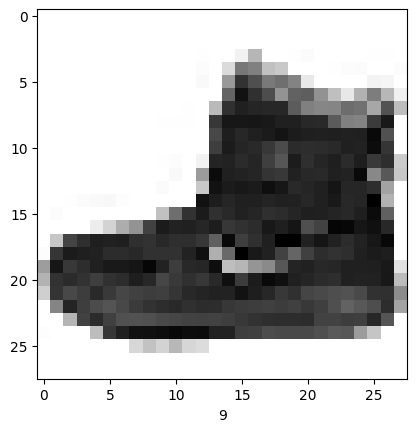

In [7]:
plt.imshow(x_train[0], cmap='binary')
plt.xlabel(y_train[0])
plt.show()

In [27]:
def create_model(hp):

  num_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if hp:
    num_hidden_layers = hp.Choice('num_hidden_layers', values = [1, 2, 3])
    num_units = hp.Choice('num_units', values = [8, 16, 32])
    dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value = 0.5)
    learning_rate = hp.Float('learning_rate', min_value = 0.0001, max_value = 0.01)

  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
  model.add(tf.keras.layers.Lambda(lambda x: x/255.))

  for _ in range(0, num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))

  model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

  model.compile(
      loss = 'sparse_categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
  )
  return model

In [28]:
create_model(None).summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 lambda_4 (Lambda)           (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 8)                 6280      
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_9 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [38]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step = 32)
    return super(CustomTuner, self).run_trial(trial, *args, **kwargs)

In [39]:
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='logs',
    project_name='fashion_mnist',
    overwrite=True
)

In [40]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}


In [41]:
tuner.search(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 5, verbose=False
)

In [42]:
tuner.results_summary(1)

Results summary
Results in logs/fashion_mnist
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 16 summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.160224595726917
learning_rate: 0.0011815918085554765
batch_size: 32
Score: 0.8634999990463257


In [43]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [47]:
_ = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs=20, batch_size = 32,
)

Epoch 1/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3564 - accuracy: 0.8686 - val_loss: 0.3737 - val_accuracy: 0.8638
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3529 - accuracy: 0.8688 - val_loss: 0.3711 - val_accuracy: 0.8688
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3489 - accuracy: 0.8702 - val_loss: 0.3764 - val_accuracy: 0.8673
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3417 - accuracy: 0.8728 - val_loss: 0.3666 - val_accuracy: 0.8696
Epoch 5/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3370 - accuracy: 0.8724 - val_loss: 0.3834 - val_accuracy: 0.8637
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3337 - accuracy: 0.8745 - val_loss: 0.3747 - val_accuracy: 0.8669
Epoch 7/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3326 - accuracy: 0.8757 - val_loss: 0.3749 - val_accuracy: